## 3. Multi-Class Classification in Theano

The aim of this IPython notebook is to show some features of the Python **Theano** library in the field of machine learning. It has been developped by the LISA group at the *University of Montreal* (see: http://deeplearning.net/software/theano/). The notebook also relies on other standard Python libraries such as *numpy*, *pandas* and *matplotlib*.

To exemplify the use of **Theano**, this notebook solves the assignments of the *Machine Learning* MOOC provided by **Coursera** (see: https://www.coursera.org/learn/machine-learning) and performed in *Stanford University* by **Andrew Ng** (see: http://www.andrewng.org/).

The original MOOC assignments should to be programmed with the **Octave** language (see: https://www.gnu.org/software/octave/).The idea with this notebook is to provide Python developpers with interesting examples programmed using **Theano**.

This notebook has been developped using the *Anaconda* Python 3.4 distribution provided by **Continuum Analytics** (see: https://www.continuum.io/). It requires the **Jupyter Notebook** (see: http://jupyter.org/).

About the author: **Francis Wolinski** has an Engineering Degree From *Ecole des Ponts ParisTech* as well as a MSc. in Artificial Intelligence and a PhD. in Computer Science from *Université Pierre et Marie Curie* (UPMC).


### 3.1 Logistic Regression

#### 3.1.1 Visualizing the data

In [1]:
import theano
import numpy as np
import theano.tensor as T
from theano.tensor.nnet import sigmoid
import scipy.io as sio
data = sio.loadmat('data/ex3data1.mat')
X, Y = data['X'], data['y'].T[0]
m = X.shape[0]

In [2]:
%matplotlib inline
import pandas as pnd
import matplotlib.pyplot as plt

def display_data(X, Y):
    example_width = int(np.sqrt(X.shape[1]))

    # Compute rows, cols
    m, n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),\
                           pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    # dataset contains 20 pixel by 20 pixel grayscale images of the digit 
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex]))
            display_array[(pad + j * (example_height + pad)):(pad + j * (example_height + pad))+example_height,\
                          (pad + i * (example_width + pad)):(pad + i * (example_width + pad))+example_width] =\
                            np.reshape(X[curr_ex], (example_height, example_width)) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break 

    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(display_array.T, cmap="Greys_r")
    
    df = pnd.DataFrame(Y.reshape((display_rows, display_cols)).T)
    df = df.replace(10,0) # 0 is mapped to 10 in Y
    print(df)

   0  1  2  3  4  5  6  7  8  9
0  2  8  3  3  4  2  5  2  2  3
1  8  2  5  7  5  2  2  6  7  1
2  9  4  9  2  5  3  4  6  0  4
3  5  5  8  8  3  6  3  7  6  1
4  7  6  6  2  0  9  1  4  7  8
5  6  1  7  7  3  9  1  3  7  3
6  2  8  7  3  7  1  8  1  5  6
7  0  2  6  7  0  1  6  7  4  5
8  2  2  8  2  9  8  3  2  7  6
9  4  5  1  4  9  9  4  4  5  9


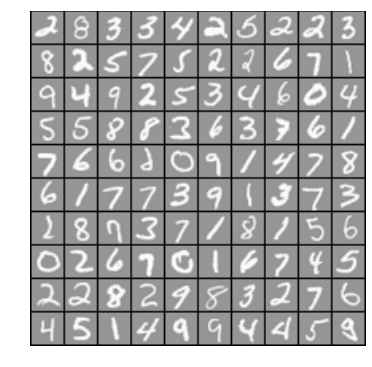

In [3]:
rnd = np.random.permutation(m)[0:100]
sel = X[rnd,:] # 100 random digits
res = Y[rnd]
display_data(sel, res)

#### 3.1.2 Logistic Regression

In [4]:
X1 = np.c_[np.ones(m), X] # Add intercept term to X
X1 = X1.T

# Choose some alpha and lambda values
alpha = 0.1
lambda_ = 0.1

num_labels = 10

all_theta = np.zeros((num_labels, X1.shape[0]))

for j in range(num_labels):
    print('Feature: %i' % (j+1))
    # Init Theta and Run Gradient Descent 
    t = np.zeros(X1.shape[0])
    theta = theano.shared(t,name='theta')

    x = T.matrix('x')
    y = T.vector('y')

    h = sigmoid(T.dot(theta,x)) # 1.0 / (1.0 + T.exp(-T.dot(theta,x)))
    reg = lambda_ * T.sum(theta[1:]**2) / 2 / m # regularization on theta
    cost = -T.sum(y * T.log(h) + (1.0 - y) * T.log (1.0 - h))/m + reg
    grad = T.grad(cost,theta)

    train = theano.function([x,y],cost,updates = [(theta,theta-alpha*grad)])

    num_iters = 100
    for i in range(num_iters):
        costM = train(X1, Y==(j+1))
        
    all_theta[j] = theta.get_value()

# number of positive predictions where best prediction == Y-1
accuracy = np.sum(np.argmax(np.dot(all_theta,X1), axis=0) == (Y-1))/len(Y)
print('\nTrain Accuracy: %f' % accuracy)

Feature: 1
Feature: 2
Feature: 3
Feature: 4
Feature: 5
Feature: 6
Feature: 7
Feature: 8
Feature: 9
Feature: 10

Train Accuracy: 0.841600


### 3.2 Neural Networks

#### 3.2.1 Model representation

In [5]:
# load precomputed network parameters
weights = sio.loadmat('data/ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

#### 3.2.2 Feedforward Propagation and Prediction

In [6]:
# layer sizes
input_layer_size = X1.shape[0]
hidden_layer_size = theta2.shape[1]
output_layer_size = theta2.shape[0]

print('input_layer_size: %i' % input_layer_size)
print('hidden_layer_size: %i' % hidden_layer_size)
print('output_layer_size: %i' % output_layer_size)

x = T.matrix('x')

# first layer
y1 = 1 / (1 + np.exp(-np.dot(theta1,X1)))

# second layer
y2 = np.c_[np.ones(m), y1.T] # Add intercept term to y1
y2 = y2.T
y3 = 1 / (1 + np.exp(-np.dot(theta2, y2)))

input_layer_size: 401
hidden_layer_size: 26
output_layer_size: 10


In [7]:
# number of positive predictions where best prediction == Y-1
accuracy = np.sum(np.argmax(y3, axis=0) == (Y-1))/len(Y)
print('Train Accuracy: %f' % accuracy)

Train Accuracy: 0.975200
